In [46]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [51]:
# Set up plotting parameters for consistent styling
plt.rcParams.update({
    # Figure size and DPI
    'figure.figsize': (10, 6),
    'figure.dpi': 100,
    
    # Font sizes
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    
    # Font family - using default sans-serif
    'font.family': 'sans-serif',
    
    # Grid settings
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    
    # Line settings
    'lines.linewidth': 2,
    'lines.markersize': 8,
    
    # Legend settings
    'legend.frameon': True,
    'legend.framealpha': 0.8,
    'legend.edgecolor': 'black',
    
    # Axes settings
    'axes.grid': True,
    'axes.linewidth': 1.5,
    
    # Tick settings
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'xtick.minor.width': 1.0,
    'ytick.minor.width': 1.0,
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'xtick.minor.size': 3,
    'ytick.minor.size': 3,
    
    # Save settings
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})

In [52]:

class NetworkSIR:
    """
    Implementation of the SIR (Susceptible-Infected-Recovered) epidemic model on complex networks.
    Uses a BA network. The infection rate is degree-dependent (β = kλ) to model the increased risk for highly-connected nodes.
    """
    
    def __init__(self, N=1000, m=2, infection_rate=0.3, recovery_rate=0.1):
        """
        Initialize the network and epidemic parameters.
        
        Parameters:
        -----------
        N : int
            Number of nodes in the network
        m : float
            Growth parameter
        infection_rate : float
            Base infection rate λ (will be multiplied by node degree k)
        recovery_rate : float
            Recovery rate μ (probability of recovery per timestep)
        """
        # Store parameters
        self.N = N                      # Network size
        self.lambda_ = infection_rate   # Base infection rate (λ)
        self.mu = recovery_rate         # Recovery rate (μ)
        
            
        #  Create network using configuration model
        self.G = nx.barabasi_albert_graph(N, m)
 
        # Initialize epidemic states
        # 0: Susceptible, 1: Infected, 2: Recovered
        self.states = np.zeros(N)
        
        # Arrays to track fraction of population in each state
        self.S = []  # Susceptible fraction over time
        self.I = []  # Infected fraction over time
        self.R = []  # Recovered fraction over time
        
    def initialize_infection(self, initial_infected=5):
        """
        Start the epidemic by randomly infecting a set of nodes.
        
        Parameters:
        -----------
        initial_infected : int
            Number of nodes to initially infect
        """
        # Ensure valid number of initial infections
        initial_infected = min(initial_infected, self.N)
        
        # Randomly choose nodes to infect
        infected_nodes = np.random.choice(self.N, initial_infected, replace=False)
        self.states[infected_nodes] = 1  # Set chosen nodes to infected state
        
        # Record initial state proportions
        s = np.sum(self.states == 0)  # Count susceptible
        i = np.sum(self.states == 1)  # Count infected
        r = np.sum(self.states == 2)  # Count recovered
        
        # Store as fractions
        self.S.append(s / self.N)
        self.I.append(i / self.N)
        self.R.append(r / self.N)
    
    def step(self):
        """
        Simulate one time step of the epidemic spread.
        
        For susceptible nodes:
        - Infection probability increases with number of infected neighbors
        - Also increases with node degree (β = kλ)
        
        For infected nodes:
        - Fixed probability μ of recovery
        """
        # Create copy of current states to update
        new_states = self.states.copy()
        
        # Update each node
        for node in range(self.N):
            if self.states[node] == 0:  # Susceptible node
                # Number node's neighbors
                neighbors = list(self.G.neighbors(node))
                # Count infected ones
                infected_neighbors = sum(self.states[n] == 1 for n in neighbors)
                
                # Calculate infection probability : P(infection) = 1 - (1-λ)^(k*i)
                degree = len(neighbors)
                infection_prob = 1 - (1 - self.lambda_) ** (degree * infected_neighbors)
                
                # Probabilistically infect
                if np.random.random() < infection_prob:
                    new_states[node] = 1
                    
            elif self.states[node] == 1:  # Infected node
                # Recover with probability μ
                if np.random.random() < self.mu:
                    new_states[node] = 2
                    
        # Update states
        self.states = new_states
        
        # Record new state proportions
        s = np.sum(self.states == 0)
        i = np.sum(self.states == 1)
        r = np.sum(self.states == 2)
        self.S.append(s / self.N)
        self.I.append(i / self.N)
        self.R.append(r / self.N)
        
    def run(self, time_steps):
        """
        Run the simulation for multiple time steps.
        """
        for _ in range(time_steps):
            self.step()
            
    def plot_results(self):
        """Plot the SIR curves"""
        plt.figure(figsize=(10, 6))
        t = np.arange(len(self.S))
        plt.plot(t, self.S, 'b-', label='Susceptible')
        plt.plot(t, self.I, 'r-', label='Infected')
        plt.plot(t, self.R, 'g-', label='Recovered')
        plt.xlabel('Time steps')
        plt.ylabel('Fraction of population')
        plt.title('SIR Model on Network')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def plot_network_state(self, ax=None, title=None):
        """Visualize the current state of the network"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 10))
            
        pos = nx.spring_layout(self.G)
        
        # Draw nodes for each state
        node_colors = ['blue' if s == 0 else 'red' if s == 1 else 'green' for s in self.states]
        nx.draw_networkx_nodes(self.G, pos, node_color=node_colors, node_size=100, ax=ax)
        nx.draw_networkx_edges(self.G, pos, alpha=0.2, ax=ax)
        
        if title:
            ax.set_title(title)
        ax.axis('off')
        
    def plot_network_states_grid(self, timepoints):
        """Plot network states at specified timepoints in a grid"""
        # Calculate grid dimensions
        n = len(timepoints)
        cols = min(3, n)
        rows = (n + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
        if rows == 1 and cols == 1:
            axes = np.array([axes])
        axes = axes.flatten()
        
        # Store initial states
        initial_states = self.states.copy()
        initial_S = self.S.copy()
        initial_I = self.I.copy()
        initial_R = self.R.copy()
        
        # Reset simulation
        self.states = np.zeros(self.N)
        self.S = []
        self.I = []
        self.R = []
        self.initialize_infection(initial_infected=5)
        
        # Plot initial state
        pos = nx.spring_layout(self.G)  # Calculate layout once and reuse
        
        for idx, t in enumerate(timepoints):
            # Run simulation up to timepoint
            if t > 0:
                self.run(t - sum(timepoints[:idx]))
            
            # Plot in corresponding subplot
            self.plot_network_state(ax=axes[idx], title=f't = {t}')
            
            # Add state percentages to title
            s_pct = np.sum(self.states == 0) / self.N * 100
            i_pct = np.sum(self.states == 1) / self.N * 100
            r_pct = np.sum(self.states == 2) / self.N * 100
            axes[idx].set_title(f't = {t}\nS: {s_pct:.1f}%, I: {i_pct:.1f}%, R: {r_pct:.1f}%')
        
        # Remove empty subplots if any
        for idx in range(len(timepoints), len(axes)):
            fig.delaxes(axes[idx])
            
        plt.tight_layout()
        plt.show()
        
        # Restore initial states
        self.states = initial_states
        self.S = initial_S
        self.I = initial_I
        self.R = initial_R


Basic reproduction number R0 = 12.00


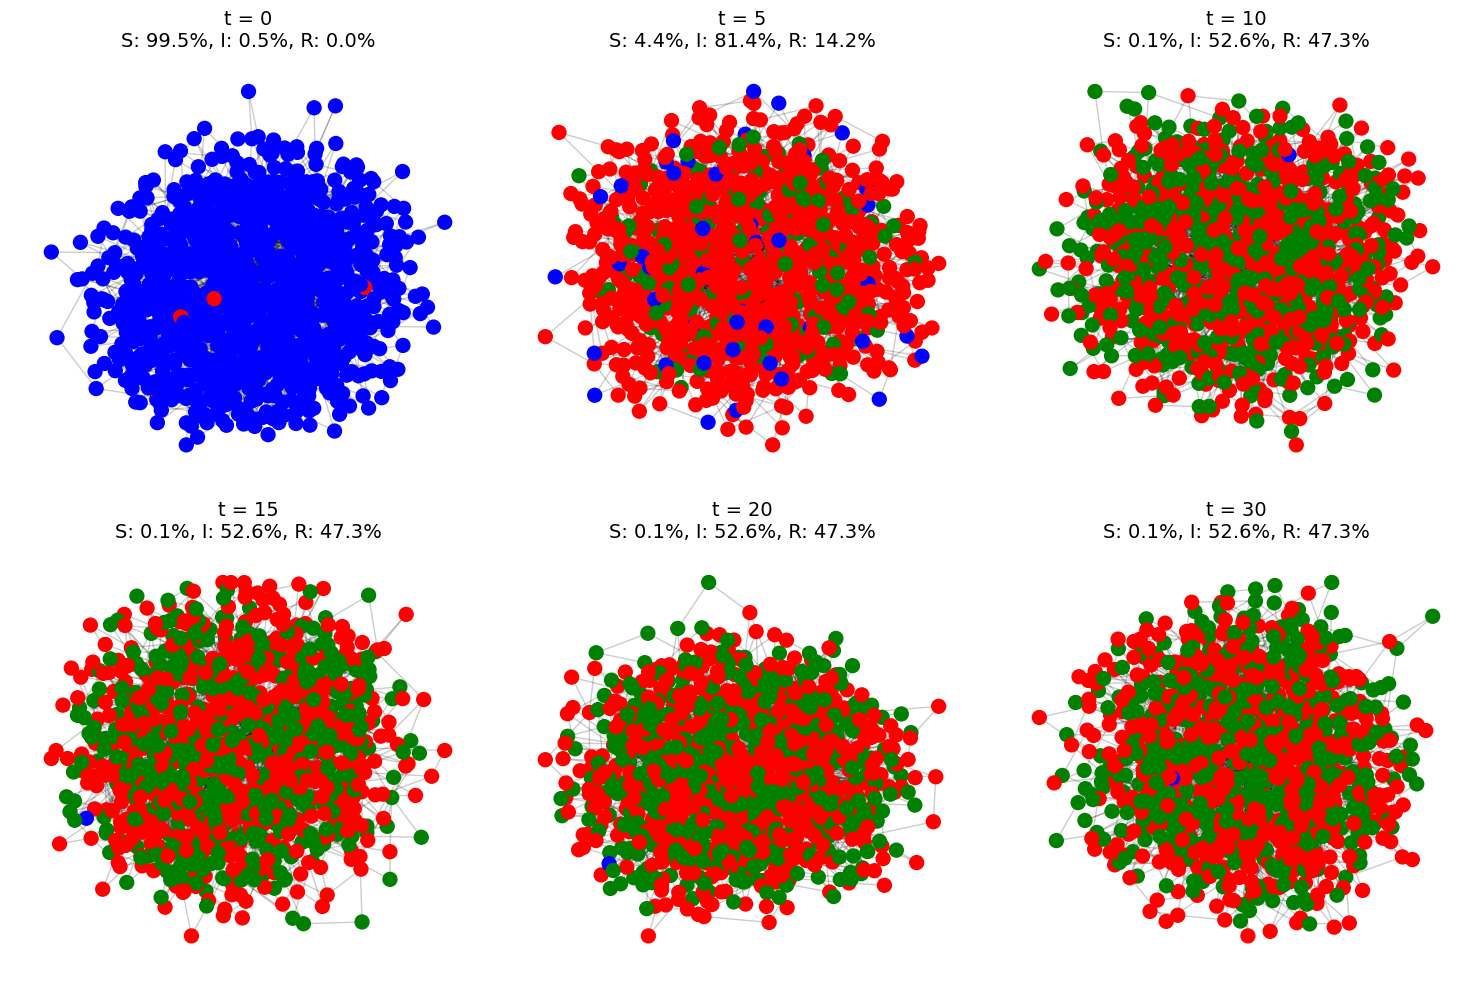

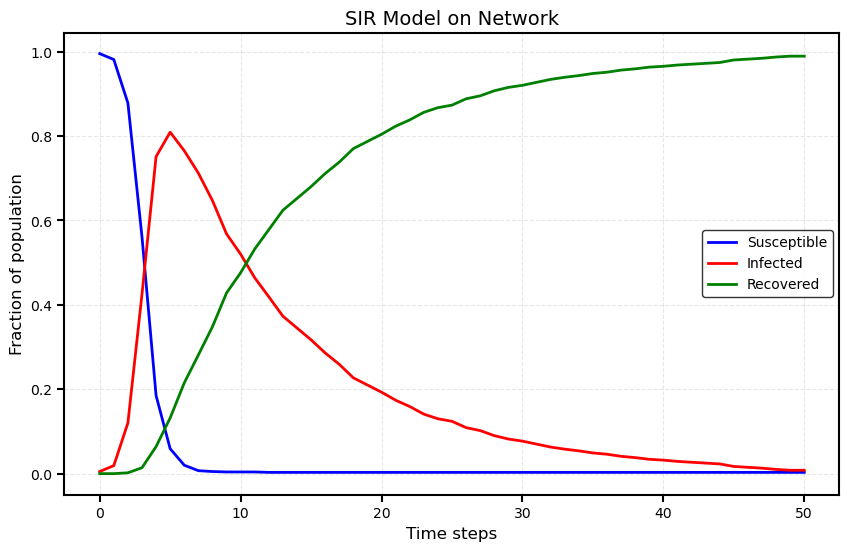

In [55]:
## Create model with R0 > 1 condition from notes
# From notes: R0 = λ<k>/μ > 1
N = 1000
m = 2
lambda_ = 0.3  # Base infection rate
mu = 0.1       # Recovery rate

# Check R0
R0 = (lambda_ * avg_degree) / mu
print(f"Basic reproduction number R0 = {R0:.2f}")

model = NetworkSIR(N=N, m=m, infection_rate=lambda_, recovery_rate=mu)

# Plot network states at specified timepoints
timepoints = [0, 5, 10, 15, 20, 30]
model.plot_network_states_grid(timepoints)

# Plot overall SIR curves
model.initialize_infection(initial_infected=5)
model.run(time_steps=50)
model.plot_results()

Basic reproduction number R0 = 12.00


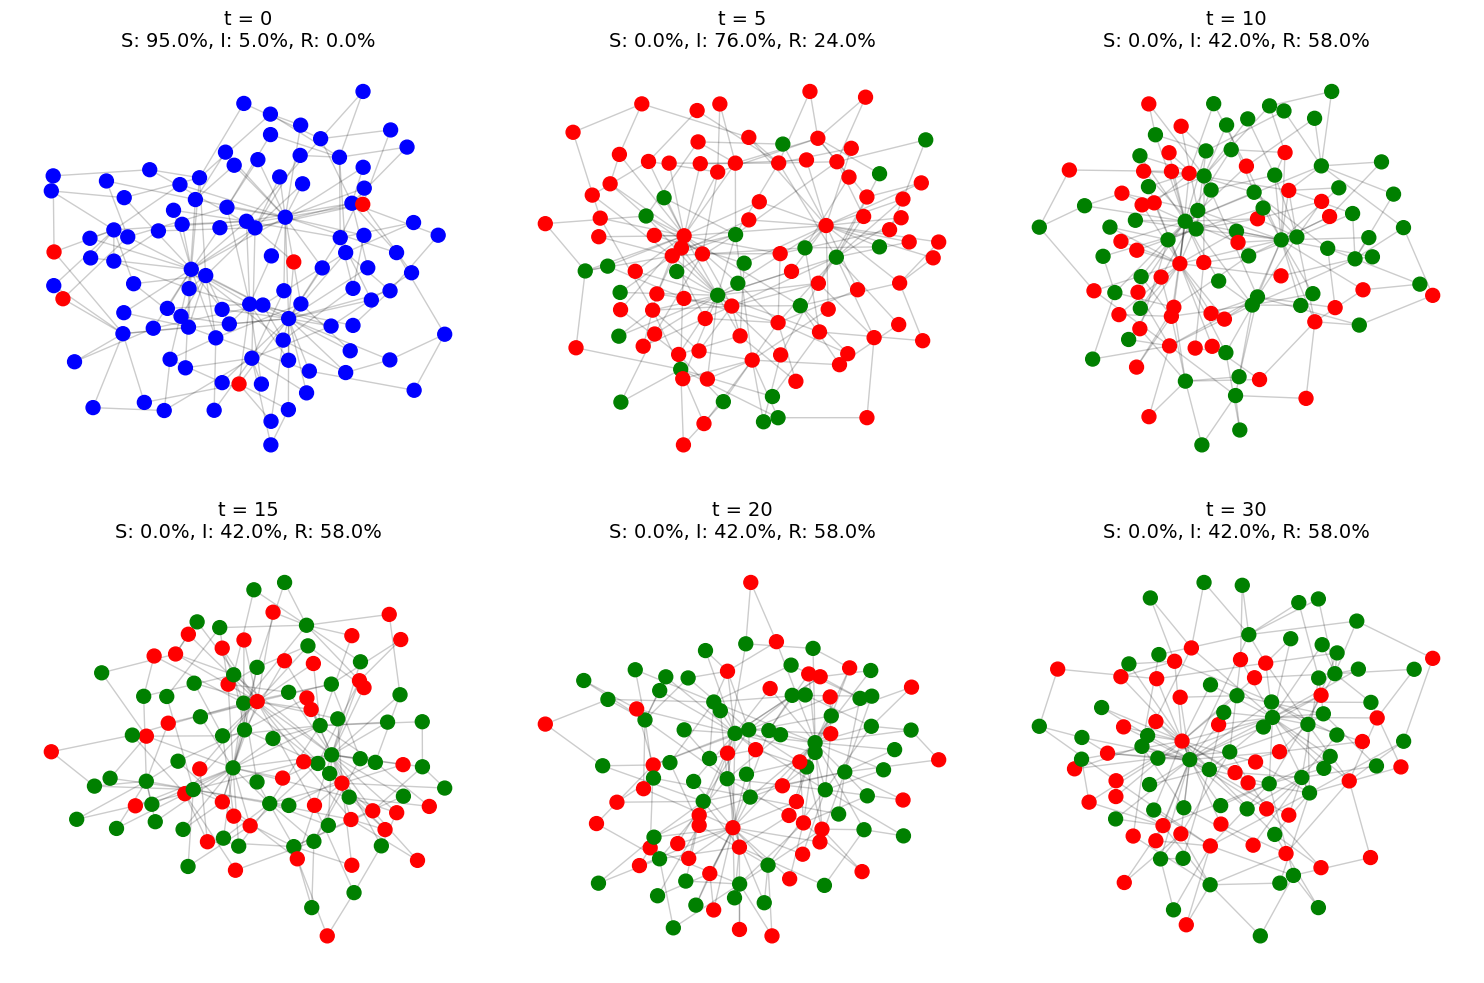

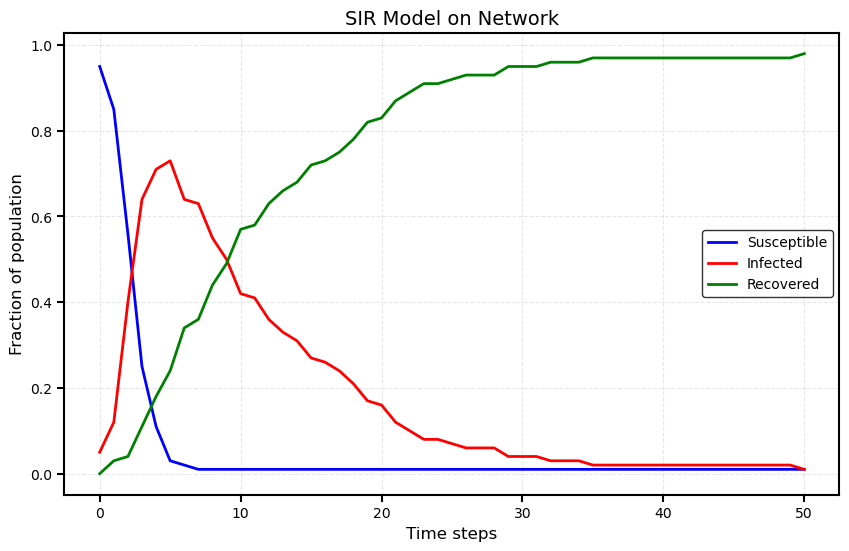

In [54]:
N = 100
m = 2
lambda_ = 0.3  # Base infection rate
mu = 0.1       # Recovery rate

# Check R0
R0 = (lambda_ * avg_degree) / mu
print(f"Basic reproduction number R0 = {R0:.2f}")

model = NetworkSIR(N=N, m=m, infection_rate=lambda_, recovery_rate=mu)

# Plot network states at specified timepoints
timepoints = [0, 5, 10, 15, 20, 30]
model.plot_network_states_grid(timepoints)

# Plot overall SIR curves
model.initialize_infection(initial_infected=5)
model.run(time_steps=50)
model.plot_results()